# Loki2 *in silico* Immunostaining

This notebook demonstrates how to prepare CRC02 patch-level data, train a LightGBM regressor on HE embeddings to predict IF channel intensity, and visualize predictions. 

## Data Requirements

The example data is stored in the directory `../data/imm_stain`, which can be donwloaded from [Google Drive](https://drive.google.com/drive/folders/19qzd8jTZBQ57a3N5xbiZFSGZJNpIz8NQ?usp=sharing).

You will need:
- Loki2 cell inference results
- Paired HE and IF patches

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

import loki2.immstain

# Display inline plots
%matplotlib inline

## Examples of PanCK Marker

### Configure paths and parameters
Set your dataset locations and model options. Update these to match your filesystem.


In [2]:
cfg = loki2.immstain.TutorialConfig(
    he_ome_path=Path("../data/imm_stain/CRC02-HE.ome.tif"),
    global_nuclei_json=Path("../data/imm_stain/CRC02-HE_PYRAMIDAL_cells.json"),
    global_embedding_pt=Path("../data/imm_stain/CRC02-HE_PYRAMIDAL_cells.pt"),
    if_patch_dir=Path("../data/imm_stain/patches_IF_lvl0_2048_sel"),
    if_patch_pattern="IF_sel_r{row:03d}_c{col:03d}.tif",
    patch_json_dir=Path("../outputs/imm_stain/CRC02_patch_cells_json"),
    patch_emb_dir=Path("../outputs/imm_stain/CRC02_patch_embeddings"),
    level0_idx=0,
    level1_idx=1,
    patch_size=2048,
)

# Training choices
target_channel = 4  # example: Pan-CK channel (0-based index in IF stack)
use_log = True      # log1p on targets
normalize_embeddings = True
extend_nuclei = True  # watershed grow nuclei to cell boundaries
expansion_distance = 5   # pixels for watershed limit

# Paths to save outputs
model_out_path = Path(f"../outputs/imm_stain/models/CRC02_lightgbm_channel{target_channel}.pt".format(ch=target_channel))
train_pred_path = Path(f"../outputs/imm_stain/predictions/CRC02_channel{target_channel}_train_predictions.json".format(ch=target_channel))
test_pred_path = Path(f"../outputs/imm_stain/predictions/CRC02_channel{target_channel}_test_predictions.json".format(ch=target_channel))

### One-time prep: generate per-patch JSON and embeddings

Step 1: Split global nuclei + embeddings into per-patch JSON/PT files (one-time prep)

Run this once to split the global nuclei JSON + embeddings into per-patch files. Skip if you already have `CRC02_patch_cells_json/` and `CRC02_patch_embeddings/` populated.

In [3]:
do_generate = True  # set True for first run

if do_generate:
    loki2.immstain.generate_patch_json_and_embeddings(cfg)
else:
    print("Skipping generation; set do_generate=True to run.")

Loading global embeddings...
Global embeddings: 1038158 cells, dim=1280
Loading global nucleus JSON...
../data/imm_stain/CRC02-HE.ome.tif level 0 zarr shape: (3, 54363, 82230)
../data/imm_stain/CRC02-HE.ome.tif level 1 zarr shape: (3, 27182, 41115)
Level0: H0=54363, W0=82230
Level1: H1=27182, W1=41115
Scale factors: scale_y=0.500009, scale_x=0.500000
Patch grid (level1): 14 rows x 21 cols
Assigning global cells to patches (level1 grid)...
Non-empty patches: 188
Saving patch JSON + embedding files...
Done generating patch-specific JSON + embeddings.


### Inspect available patches
List patches that have both nuclei/embedding JSON and IF patch present.

In [4]:
available_patches = loki2.immstain.list_available_patches(cfg)
print(f"Found {len(available_patches)} patches with both JSON/emb and IF:")
print(available_patches)  # show a sample
# use those patches for quick testing
available_patches=['r004_c006','r004_c005','r004_c007','r003_c006']

Found 4 patches with both JSON/emb and IF:
['r003_c006', 'r004_c005', 'r004_c006', 'r004_c007']


### Define train/val/test patch splits
Select a validation patch (held out from train) and optional test patches for final evaluation/visualization.

In [5]:
# Simple deterministic split example (edit as needed)
if len(available_patches) < 3:
    raise RuntimeError("Need at least 3 patches to run train/val/test example.")

val_patch = available_patches[0]
train_patches = available_patches[1:-1]
test_patches = [available_patches[-1]]

print("Validation patch:", val_patch)
print("Train patches (count):", len(train_patches))
print("Test patches:", test_patches)

Validation patch: r004_c006
Train patches (count): 2
Test patches: ['r003_c006']


### Build datasets

Step 2: Build train/val/test cell-level datasets for a chosen IF channel

Creates cell-level feature matrix `X`, targets `y`, and metadata for the chosen IF channel.

In [6]:
with loki2.immstain.timed_section(f"build train dataset (channel {target_channel})"):
    X_train, y_train, meta_train = loki2.immstain.build_dataset_for_patches(
        cfg,
        train_patches,
        channel_idx=target_channel,
        guide_channel=None,
        expansion_distance=expansion_distance,
        extend_nuclei=extend_nuclei
    )

with loki2.immstain.timed_section(f"build val dataset (channel {target_channel})"):
    X_val, y_val, meta_val = loki2.immstain.build_dataset_for_patches(
        cfg,
        [val_patch],
        channel_idx=target_channel,
        guide_channel=None,
        expansion_distance=expansion_distance,
        extend_nuclei=extend_nuclei
    )

print("Train shape", X_train.shape, "Val shape", X_val.shape)


Processing patch r004_c005...
  N nuclei in patch JSON: 16911
  Patch embeddings shape: (16911, 1280)

Processing patch r004_c007...
  N nuclei in patch JSON: 16068
  Patch embeddings shape: (16068, 1280)

Total cells across all patches: 32979, embedding dim=1280
[timer] build train dataset (channel 4): 146.89s

Processing patch r004_c006...
  N nuclei in patch JSON: 15974
  Patch embeddings shape: (15974, 1280)

Total cells across all patches: 15974, embedding dim=1280
[timer] build val dataset (channel 4): 48.28s
Train shape (32979, 1280) Val shape (15974, 1280)


### Preprocess features and targets
Optionally L2-normalize embeddings and log-transform targets (log1p).

In [7]:
def prep_features(X):
    if not normalize_embeddings:
        return X.copy()
    return loki2.immstain.l2_normalize_embeddings(X.copy())

prep_target = (np.log1p if use_log else (lambda x: x.copy()))

X_train_proc = prep_features(X_train)
X_val_proc = prep_features(X_val)
y_train_proc = prep_target(y_train)
y_val_proc = prep_target(y_val)

print("Preprocessed shapes:", X_train_proc.shape, X_val_proc.shape)

Preprocessed shapes: (32979, 1280) (15974, 1280)


### Train LightGBM with patch-level validation

Step 3: Train a LightGBM regressor with per-patch holdout validation

Only the LightGBM model is used to keep the pipeline focused.

In [8]:
with loki2.immstain.timed_section("train lightgbm"):
    model, val_metrics, y_val_pred = loki2.immstain.train_lightgbm_regressor(
        X_train_proc,
        y_train_proc,
        X_val_proc,
        y_val_proc,
        random_state=42,
        num_boost_round=2000,
        early_stopping_rounds=100,
    )

print("Validation metrics:", json.dumps(val_metrics, indent=2))

# Train predictions (for diagnostics on processed scale)
y_train_pred = loki2.immstain.predict_with_model(model, X_train_proc)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.603496	valid's rmse: 0.829716
[200]	train's rmse: 0.48877	valid's rmse: 0.821889
[300]	train's rmse: 0.405244	valid's rmse: 0.819101
[400]	train's rmse: 0.340861	valid's rmse: 0.817872
[500]	train's rmse: 0.289398	valid's rmse: 0.817132
[600]	train's rmse: 0.247122	valid's rmse: 0.816637
[700]	train's rmse: 0.211582	valid's rmse: 0.816496
[800]	train's rmse: 0.182258	valid's rmse: 0.816471
Early stopping, best iteration is:
[720]	train's rmse: 0.205237	valid's rmse: 0.81629
[timer] train lightgbm: 2431.94s
Validation metrics: {
  "mse": 0.6663286154146737,
  "mae": 0.6359814654748486,
  "r2": 0.3973233849316552,
  "pearson_r": 0.6339607099617551,
  "ssim": 0.3455918097967648,
  "model_type": "lightgbm"
}


### Optional: test set evaluation
Evaluate on held-out patches (if provided) and collect predictions.

In [9]:
test_results = None
if test_patches:
    with loki2.immstain.timed_section(f"build test dataset (channel {target_channel})"):
        X_test, y_test, meta_test = loki2.immstain.build_dataset_for_patches(
            cfg,
            test_patches,
            channel_idx=target_channel,
            guide_channel=None,
            expansion_distance=expansion_distance,
            extend_nuclei=extend_nuclei
        )
    X_test_proc = prep_features(X_test)
    y_test_proc = prep_target(y_test)
    with loki2.immstain.timed_section("predict test"):
        y_test_pred = loki2.immstain.predict_with_model(model, X_test_proc)
    if use_log:
        y_test_eval = y_test
        y_test_pred_eval = np.expm1(y_test_pred)
    else:
        y_test_eval = y_test
        y_test_pred_eval = y_test_pred
    test_metrics = loki2.immstain.compute_regression_metrics(y_test_eval, y_test_pred_eval)
    print("Test metrics (original scale):", json.dumps(test_metrics, indent=2))
    test_results = {
        "X": X_test_proc,
        "y_true": y_test_proc,
        "y_pred": y_test_pred,
        "meta": meta_test,
        "metrics": test_metrics,
        "y_true_raw": y_test_eval,
        "y_pred_raw": y_test_pred_eval,
    }
else:
    print("No test patches provided; skip test evaluation.")


Processing patch r003_c006...
  N nuclei in patch JSON: 14871
  Patch embeddings shape: (14871, 1280)

Total cells across all patches: 14871, embedding dim=1280
[timer] build test dataset (channel 4): 59.56s
[timer] predict test: 0.08s
Test metrics (original scale): {
  "mse": 8509761.026050935,
  "mae": 1978.1806053469938,
  "r2": 0.059515598904488654,
  "pearson_r": 0.39398436519666197,
  "ssim": 0.30092517473176844
}


### Save model and predictions

Step 4: Save per-cell predictions to JSON and plot diagnostics (pred vs. true, residuals)

Persist the trained model plus per-cell prediction JSON for train/val/test splits.

In [10]:
# Save model bundle
model_out_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(
    {
        "model": model,
        "normalize_embeddings": normalize_embeddings,
        "use_log": use_log,
        "metrics": val_metrics,
    },
    model_out_path,
)
print(f"Saved model to {model_out_path}")

# Save train predictions (processed scale)
loki2.immstain.save_prediction_json(
    train_pred_path,
    channel_idx=target_channel,
    extend_nuclei=extend_nuclei,
    normalize_embeddings=normalize_embeddings,
    metrics=val_metrics,
    meta=meta_train,
    y_true=y_train_proc,
    y_pred=y_train_pred,
)

# Save test predictions if available
loki2.immstain.save_prediction_json(
    test_pred_path,
    channel_idx=target_channel,
    extend_nuclei=extend_nuclei,
    normalize_embeddings=normalize_embeddings,
    metrics=(test_results or {}).get("metrics", val_metrics),
    meta=(test_results or {}).get("meta", []),
    y_true=(test_results or {}).get("y_true", []),
    y_pred=(test_results or {}).get("y_pred", []),
)

Saved model to ../outputs/imm_stain/models/CRC02_lightgbm_channel4.pt
Per-cell predictions saved to: ../outputs/imm_stain/predictions/CRC02_channel4_train_predictions.json
Per-cell predictions saved to: ../outputs/imm_stain/predictions/CRC02_channel4_test_predictions.json


### Visualize predictions
Quick scatter and residual plots on validation predictions (processed scale). For raw-scale plots, invert log1p before plotting.

### Patch-level GT vs Pred visualization
Render one patch with per-cell measured IF intensity, predicted intensity, residual heatmap, and scatter. Uses the saved prediction JSON.

Saved patch visualization to ../outputs/imm_stain/figures_viz_only/patch_r004_c007_ch4_tutorial.png


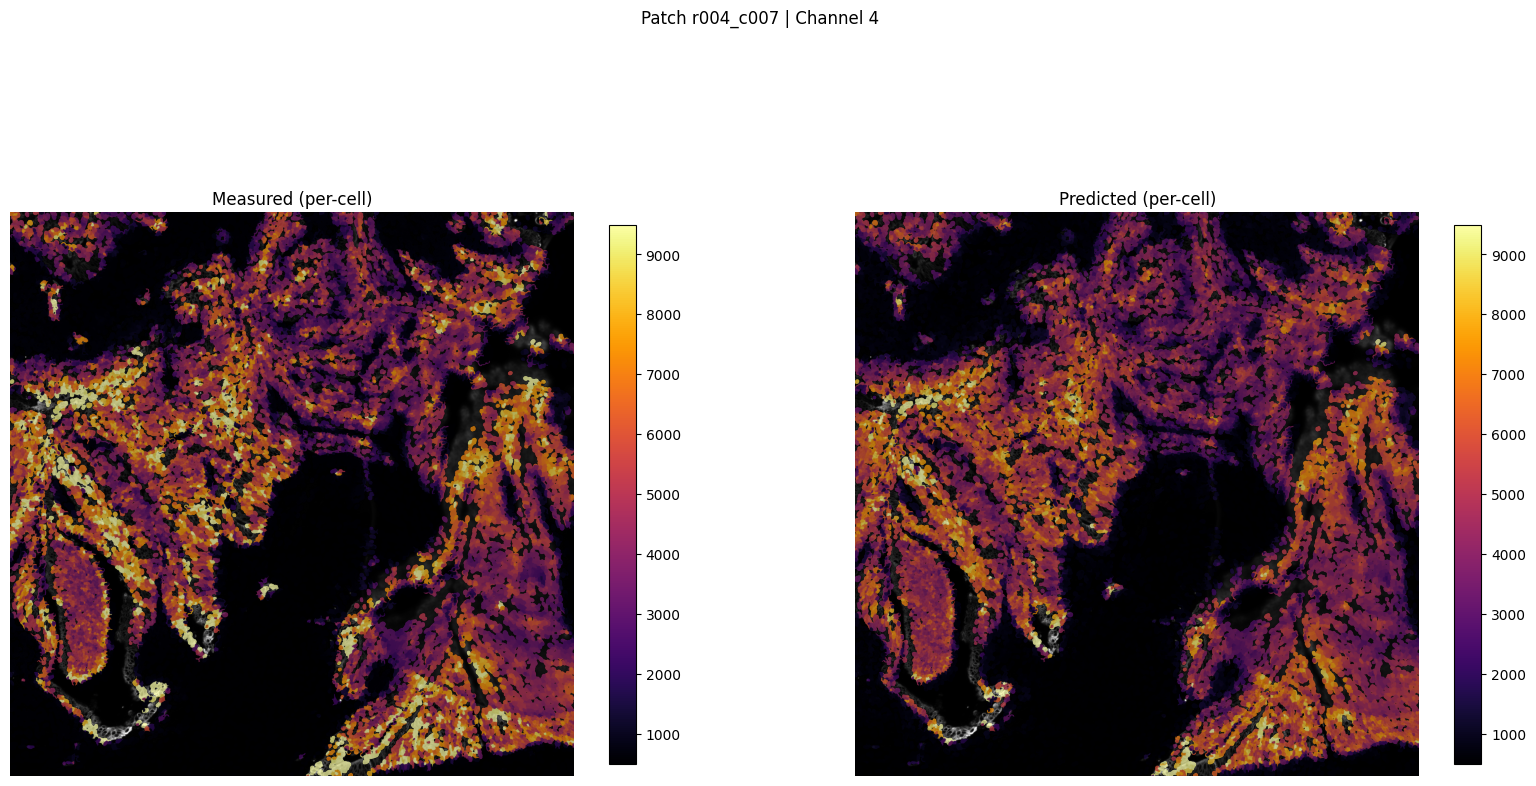

Saved patch viz to ../outputs/imm_stain/figures_viz_only/patch_r004_c007_ch4_tutorial.png


In [11]:
patch_for_viz = 'r004_c007'
pred_json_for_viz = train_pred_path
out_path = Path("../outputs/imm_stain") / "figures_viz_only" / f"patch_{patch_for_viz}_ch{target_channel}_tutorial.png"

fig, axes = loki2.immstain.visualize_patch_prediction(
    cfg,
    patch_name=patch_for_viz,
    prediction_json_path=pred_json_for_viz,
    channel_idx=target_channel,
    guide_channel=None,
    expansion_distance=expansion_distance,
    extend_nuclei=extend_nuclei,
    predictions_are_log=use_log,
    colorbar_range=None,
    save_path=out_path
)
plt.show()
print(f"Saved patch viz to {out_path}")

Saved patch visualization to ../outputs/imm_stain/figures_viz_only/patch_r003_c006_ch4_tutorial.png


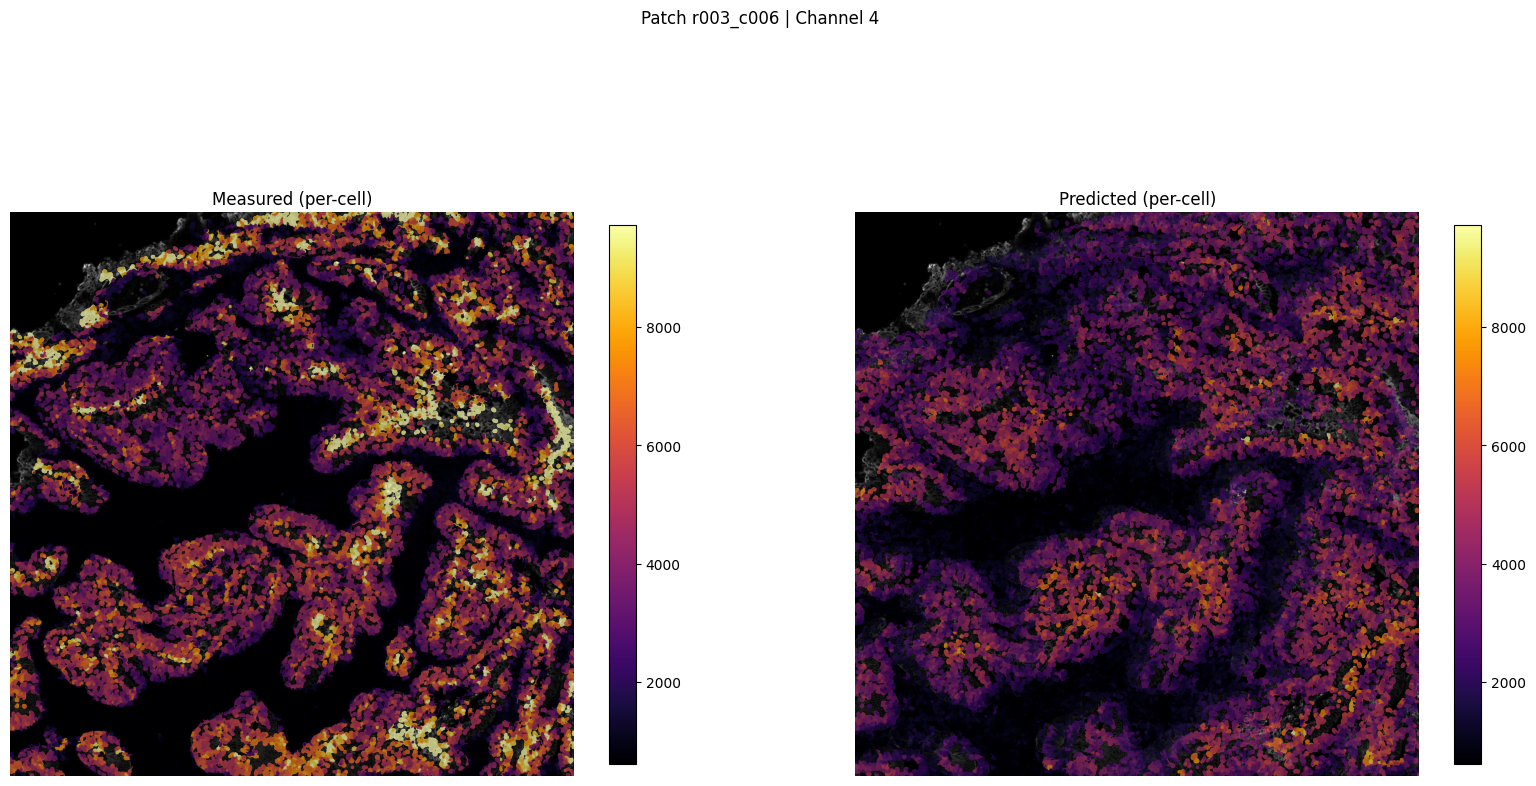

Saved patch viz to ../outputs/imm_stain/figures_viz_only/patch_r003_c006_ch4_tutorial.png


In [12]:
patch_for_viz = test_patches[0] if test_patches else val_patch
pred_json_for_viz = test_pred_path if test_patches else train_pred_path
out_path = Path("../outputs/imm_stain") / "figures_viz_only" / f"patch_{patch_for_viz}_ch{target_channel}_tutorial.png"

fig, axes = loki2.immstain.visualize_patch_prediction(
    cfg,
    patch_name=patch_for_viz,
    prediction_json_path=pred_json_for_viz,
    channel_idx=target_channel,
    guide_channel=None,
    expansion_distance=expansion_distance,
    extend_nuclei=extend_nuclei,
    predictions_are_log=use_log,
    colorbar_range=None,
    save_path=out_path
)
plt.show()
print(f"Saved patch viz to {out_path}")

## Examples of CD45RO Marker

### Configure paths and parameters
Set your dataset locations and model options. Update these to match your filesystem.


In [13]:
cfg = loki2.immstain.TutorialConfig(
    he_ome_path=Path("../data/imm_stain/CRC02-HE.ome.tif"),
    global_nuclei_json=Path("../data/imm_stain/CRC02-HE_PYRAMIDAL_cells.json"),
    global_embedding_pt=Path("../data/imm_stain/CRC02-HE_PYRAMIDAL_cells.pt"),
    if_patch_dir=Path("../data/imm_stain/patches_IF_lvl0_2048_sel"),
    if_patch_pattern="IF_sel_r{row:03d}_c{col:03d}.tif",
    patch_json_dir=Path("../outputs/imm_stain/CRC02_patch_cells_json"),
    patch_emb_dir=Path("../outputs/imm_stain/CRC02_patch_embeddings"),
    level0_idx=0,
    level1_idx=1,
    patch_size=2048,
)

# Training choices
target_channel = 2
use_log = True      # log1p on targets
normalize_embeddings = True
extend_nuclei = True  # watershed grow nuclei to cell boundaries
expansion_distance = 5   # pixels for watershed limit

# Paths to save outputs
model_out_path = Path(f"../outputs/imm_stain/models/CRC02_lightgbm_channel{target_channel}.pt".format(ch=target_channel))
train_pred_path = Path(f"../outputs/imm_stain/predictions/CRC02_channel{target_channel}_train_predictions.json".format(ch=target_channel))
test_pred_path = Path(f"../outputs/imm_stain/predictions/CRC02_channel{target_channel}_test_predictions.json".format(ch=target_channel))

### One-time prep: generate per-patch JSON and embeddings

Step 1: Split global nuclei + embeddings into per-patch JSON/PT files (one-time prep)

Run this once to split the global nuclei JSON + embeddings into per-patch files. Skip if you already have `CRC02_patch_cells_json/` and `CRC02_patch_embeddings/` populated.

In [14]:
do_generate = True  # set True for first run

if do_generate:
    loki2.immstain.generate_patch_json_and_embeddings(cfg)
else:
    print("Skipping generation; set do_generate=True to run.")

Loading global embeddings...
Global embeddings: 1038158 cells, dim=1280
Loading global nucleus JSON...
../data/imm_stain/CRC02-HE.ome.tif level 0 zarr shape: (3, 54363, 82230)
../data/imm_stain/CRC02-HE.ome.tif level 1 zarr shape: (3, 27182, 41115)
Level0: H0=54363, W0=82230
Level1: H1=27182, W1=41115
Scale factors: scale_y=0.500009, scale_x=0.500000
Patch grid (level1): 14 rows x 21 cols
Assigning global cells to patches (level1 grid)...
Non-empty patches: 188
Saving patch JSON + embedding files...
Done generating patch-specific JSON + embeddings.


### Inspect available patches
List patches that have both nuclei/embedding JSON and IF patch present.

In [15]:
available_patches = loki2.immstain.list_available_patches(cfg)
print(f"Found {len(available_patches)} patches with both JSON/emb and IF:")
print(available_patches)  # show a sample
# use those patches for quick testing
available_patches=['r004_c006','r004_c005','r004_c007','r003_c006']

Found 4 patches with both JSON/emb and IF:
['r003_c006', 'r004_c005', 'r004_c006', 'r004_c007']


### Define train/val/test patch splits
Select a validation patch (held out from train) and optional test patches for final evaluation/visualization.

In [16]:
# Simple deterministic split example (edit as needed)
if len(available_patches) < 3:
    raise RuntimeError("Need at least 3 patches to run train/val/test example.")

val_patch = available_patches[0]
train_patches = available_patches[1:-1]
test_patches = [available_patches[-1]]

print("Validation patch:", val_patch)
print("Train patches (count):", len(train_patches))
print("Test patches:", test_patches)

Validation patch: r004_c006
Train patches (count): 2
Test patches: ['r003_c006']


### Build datasets

Step 2: Build train/val/test cell-level datasets for a chosen IF channel

Creates cell-level feature matrix `X`, targets `y`, and metadata for the chosen IF channel.

In [17]:
with loki2.immstain.timed_section(f"build train dataset (channel {target_channel})"):
    X_train, y_train, meta_train = loki2.immstain.build_dataset_for_patches(
        cfg,
        train_patches,
        channel_idx=target_channel,
        guide_channel=None,
        expansion_distance=expansion_distance,
        extend_nuclei=extend_nuclei
    )

with loki2.immstain.timed_section(f"build val dataset (channel {target_channel})"):
    X_val, y_val, meta_val = loki2.immstain.build_dataset_for_patches(
        cfg,
        [val_patch],
        channel_idx=target_channel,
        guide_channel=None,
        expansion_distance=expansion_distance,
        extend_nuclei=extend_nuclei
    )

print("Train shape", X_train.shape, "Val shape", X_val.shape)


Processing patch r004_c005...
  N nuclei in patch JSON: 16911
  Patch embeddings shape: (16911, 1280)

Processing patch r004_c007...
  N nuclei in patch JSON: 16068
  Patch embeddings shape: (16068, 1280)

Total cells across all patches: 32979, embedding dim=1280
[timer] build train dataset (channel 2): 122.62s

Processing patch r004_c006...
  N nuclei in patch JSON: 15974
  Patch embeddings shape: (15974, 1280)

Total cells across all patches: 15974, embedding dim=1280
[timer] build val dataset (channel 2): 49.36s
Train shape (32979, 1280) Val shape (15974, 1280)


### Preprocess features and targets
Optionally L2-normalize embeddings and log-transform targets (log1p).

In [18]:
def prep_features(X):
    if not normalize_embeddings:
        return X.copy()
    return loki2.immstain.l2_normalize_embeddings(X.copy())

prep_target = (np.log1p if use_log else (lambda x: x.copy()))

X_train_proc = prep_features(X_train)
X_val_proc = prep_features(X_val)
y_train_proc = prep_target(y_train)
y_val_proc = prep_target(y_val)

print("Preprocessed shapes:", X_train_proc.shape, X_val_proc.shape)

Preprocessed shapes: (32979, 1280) (15974, 1280)


### Train LightGBM with patch-level validation

Step 3: Train a LightGBM regressor with per-patch holdout validation

Only the LightGBM model is used to keep the pipeline focused.

In [19]:
with loki2.immstain.timed_section("train lightgbm"):
    model, val_metrics, y_val_pred = loki2.immstain.train_lightgbm_regressor(
        X_train_proc,
        y_train_proc,
        X_val_proc,
        y_val_proc,
        random_state=42,
        num_boost_round=2000,
        early_stopping_rounds=100,
    )

print("Validation metrics:", json.dumps(val_metrics, indent=2))

# Train predictions (for diagnostics on processed scale)
y_train_pred = loki2.immstain.predict_with_model(model, X_train_proc)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.463894	valid's rmse: 0.642342
Early stopping, best iteration is:
[69]	train's rmse: 0.496389	valid's rmse: 0.642156
[timer] train lightgbm: 653.69s
Validation metrics: {
  "mse": 0.41236442882565294,
  "mae": 0.5030152276674281,
  "r2": 0.11654008841836616,
  "pearson_r": 0.3525812000093537,
  "ssim": 0.1934759306385396,
  "model_type": "lightgbm"
}


### Optional: test set evaluation
Evaluate on held-out patches (if provided) and collect predictions.

In [20]:
test_results = None
if test_patches:
    with loki2.immstain.timed_section(f"build test dataset (channel {target_channel})"):
        X_test, y_test, meta_test = loki2.immstain.build_dataset_for_patches(
            cfg,
            test_patches,
            channel_idx=target_channel,
            guide_channel=None,
            expansion_distance=expansion_distance,
            extend_nuclei=extend_nuclei
        )
    X_test_proc = prep_features(X_test)
    y_test_proc = prep_target(y_test)
    with loki2.immstain.timed_section("predict test"):
        y_test_pred = loki2.immstain.predict_with_model(model, X_test_proc)
    if use_log:
        y_test_eval = y_test
        y_test_pred_eval = np.expm1(y_test_pred)
    else:
        y_test_eval = y_test
        y_test_pred_eval = y_test_pred
    test_metrics = loki2.immstain.compute_regression_metrics(y_test_eval, y_test_pred_eval)
    print("Test metrics (original scale):", json.dumps(test_metrics, indent=2))
    test_results = {
        "X": X_test_proc,
        "y_true": y_test_proc,
        "y_pred": y_test_pred,
        "meta": meta_test,
        "metrics": test_metrics,
        "y_true_raw": y_test_eval,
        "y_pred_raw": y_test_pred_eval,
    }
else:
    print("No test patches provided; skip test evaluation.")


Processing patch r003_c006...
  N nuclei in patch JSON: 14871
  Patch embeddings shape: (14871, 1280)

Total cells across all patches: 14871, embedding dim=1280
[timer] build test dataset (channel 2): 45.82s
[timer] predict test: 0.03s
Test metrics (original scale): {
  "mse": 9694314.333038595,
  "mae": 1913.4060172446673,
  "r2": 0.13078191878753087,
  "pearson_r": 0.4336573916030431,
  "ssim": 0.37258682884705424
}


### Save model and predictions

Step 4: Save per-cell predictions to JSON and plot diagnostics (pred vs. true, residuals)

Persist the trained model plus per-cell prediction JSON for train/val/test splits.

In [21]:
# Save model bundle
model_out_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(
    {
        "model": model,
        "normalize_embeddings": normalize_embeddings,
        "use_log": use_log,
        "metrics": val_metrics,
    },
    model_out_path,
)
print(f"Saved model to {model_out_path}")

# Save train predictions (processed scale)
loki2.immstain.save_prediction_json(
    train_pred_path,
    channel_idx=target_channel,
    extend_nuclei=extend_nuclei,
    normalize_embeddings=normalize_embeddings,
    metrics=val_metrics,
    meta=meta_train,
    y_true=y_train_proc,
    y_pred=y_train_pred,
)

# Save test predictions if available
loki2.immstain.save_prediction_json(
    test_pred_path,
    channel_idx=target_channel,
    extend_nuclei=extend_nuclei,
    normalize_embeddings=normalize_embeddings,
    metrics=(test_results or {}).get("metrics", val_metrics),
    meta=(test_results or {}).get("meta", []),
    y_true=(test_results or {}).get("y_true", []),
    y_pred=(test_results or {}).get("y_pred", []),
)

Saved model to ../outputs/imm_stain/models/CRC02_lightgbm_channel2.pt
Per-cell predictions saved to: ../outputs/imm_stain/predictions/CRC02_channel2_train_predictions.json
Per-cell predictions saved to: ../outputs/imm_stain/predictions/CRC02_channel2_test_predictions.json


### Visualize predictions
Quick scatter and residual plots on validation predictions (processed scale). For raw-scale plots, invert log1p before plotting.

### Patch-level GT vs Pred visualization
Render one patch with per-cell measured IF intensity, predicted intensity, residual heatmap, and scatter. Uses the saved prediction JSON.

Saved patch visualization to ../outputs/imm_stain/figures_viz_only/patch_r004_c007_ch2_tutorial.png


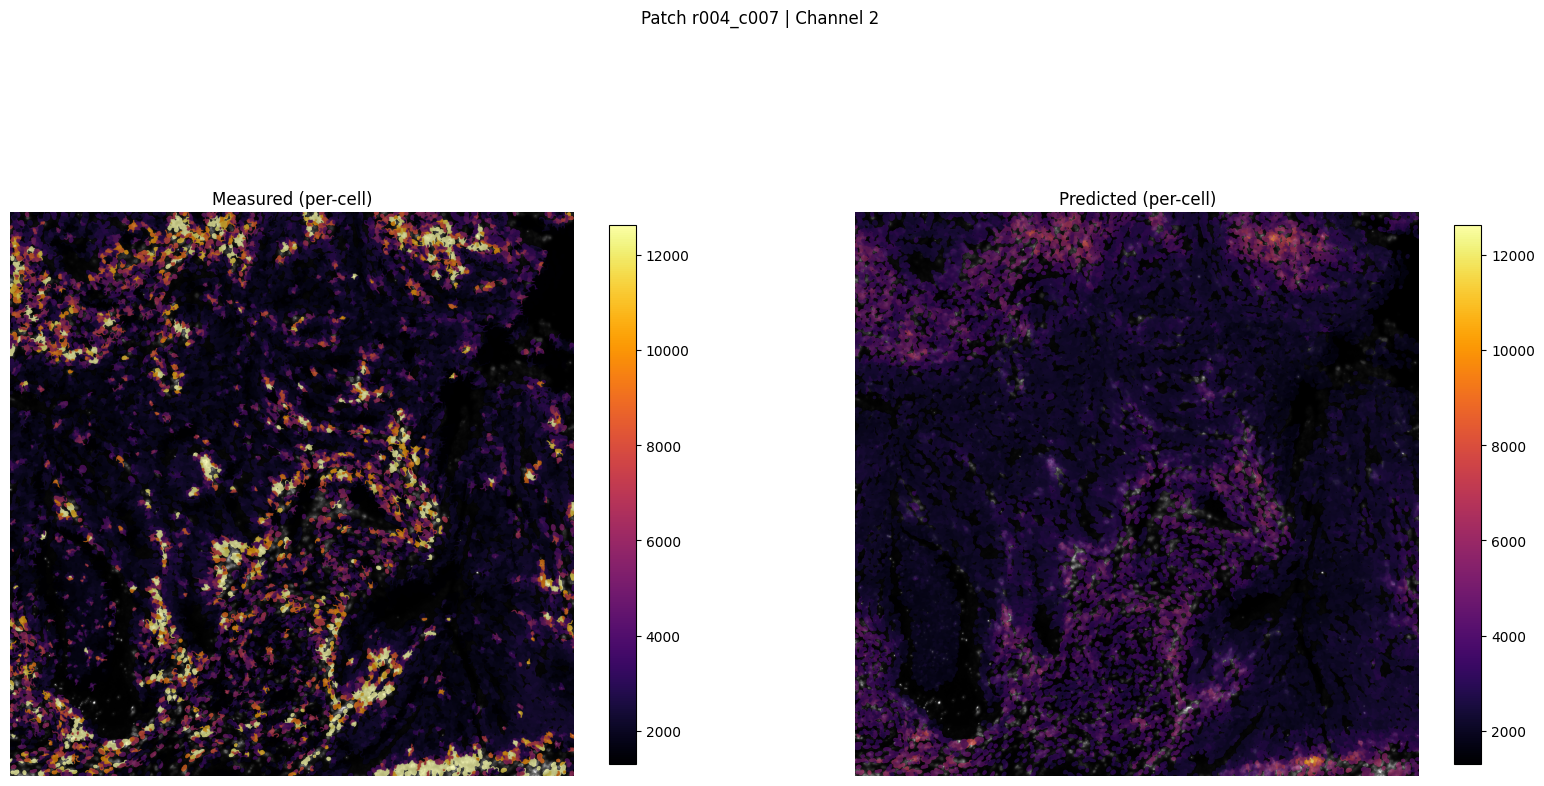

Saved patch viz to ../outputs/imm_stain/figures_viz_only/patch_r004_c007_ch2_tutorial.png


In [22]:
patch_for_viz = 'r004_c007'
pred_json_for_viz = train_pred_path
out_path = Path("../outputs/imm_stain") / "figures_viz_only" / f"patch_{patch_for_viz}_ch{target_channel}_tutorial.png"

fig, axes = loki2.immstain.visualize_patch_prediction(
    cfg,
    patch_name=patch_for_viz,
    prediction_json_path=pred_json_for_viz,
    channel_idx=target_channel,
    guide_channel=None,
    expansion_distance=expansion_distance,
    extend_nuclei=extend_nuclei,
    predictions_are_log=use_log,
    colorbar_range=None,
    save_path=out_path
)
plt.show()
print(f"Saved patch viz to {out_path}")

Saved patch visualization to ../outputs/imm_stain/figures_viz_only/patch_r003_c006_ch2_tutorial.png


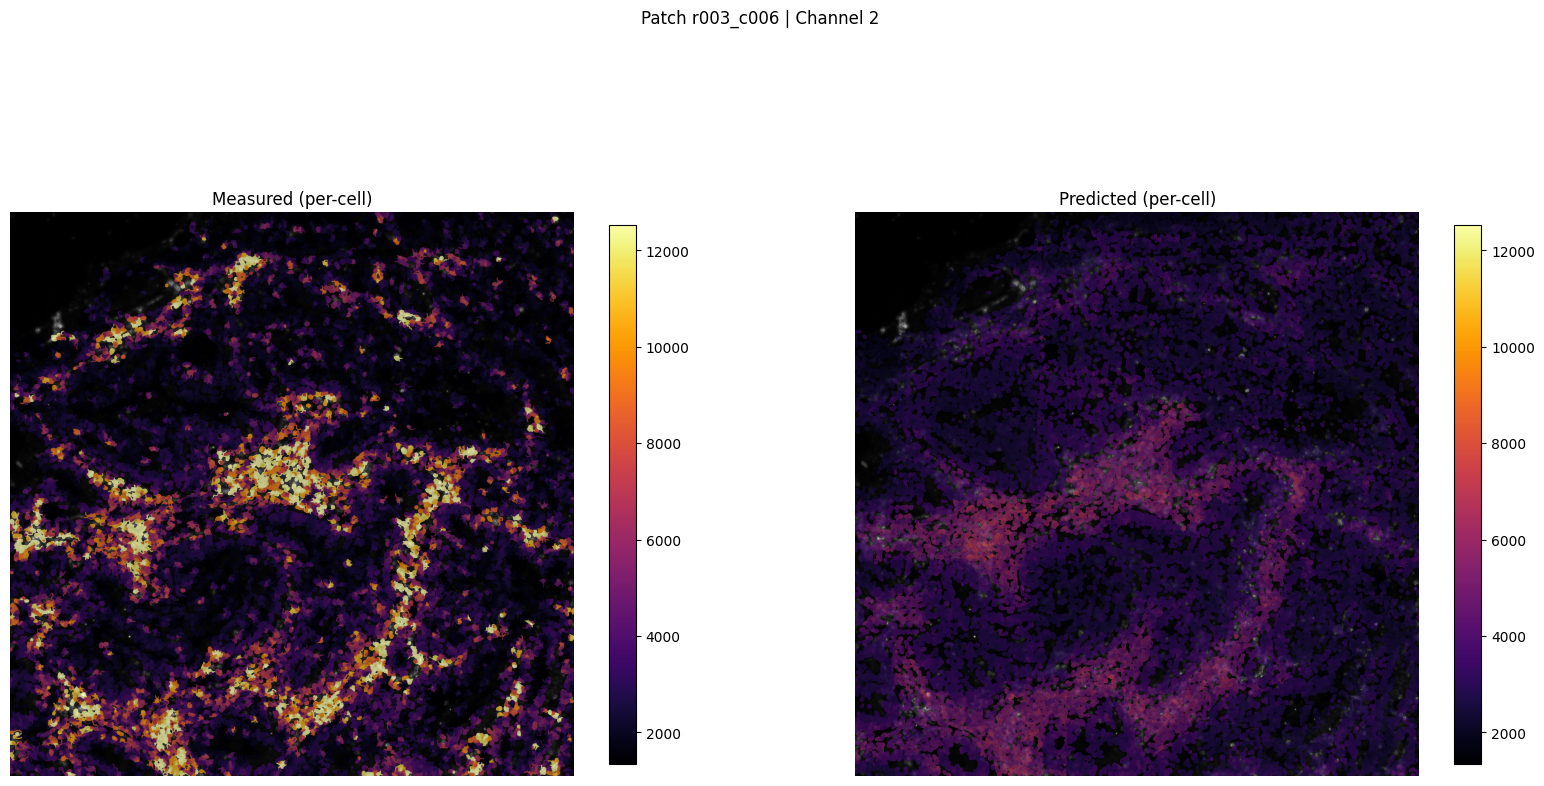

Saved patch viz to ../outputs/imm_stain/figures_viz_only/patch_r003_c006_ch2_tutorial.png


In [23]:
patch_for_viz = test_patches[0] if test_patches else val_patch
pred_json_for_viz = test_pred_path if test_patches else train_pred_path
out_path = Path("../outputs/imm_stain") / "figures_viz_only" / f"patch_{patch_for_viz}_ch{target_channel}_tutorial.png"

fig, axes = loki2.immstain.visualize_patch_prediction(
    cfg,
    patch_name=patch_for_viz,
    prediction_json_path=pred_json_for_viz,
    channel_idx=target_channel,
    guide_channel=None,
    expansion_distance=expansion_distance,
    extend_nuclei=extend_nuclei,
    predictions_are_log=use_log,
    colorbar_range=None,
    save_path=out_path
)
plt.show()
print(f"Saved patch viz to {out_path}")